In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# VotingClassifier

Идея `VotingClassifier` состоит в том, чтобы объединить принципиально разные классификаторы машинного обучения и использовать большинство голосов(жесткое голосование) или средние прогнозируемые вероятности (мягкое голосование) для прогнозирования меток классов. 

Такой классификатор может быть полезен для набора одинаково хорошо работающих моделей, чтобы сбалансировать их индивидуальные недостатки.

## Жесткое головование

При жестком голосовании прогнозируемая метка класса для конкретной выборки представляет собой метку класса, которая определяется большинством меток классов, предсказанных каждым отдельным классификатором.

Например, если прогноз для данной выборки:

классификатор 1 -> класс 1\
классификатор 2 -> класс 1\
классификатор 3 -> класс 2

Классификатор VotingClassifier (с голосованием='hard') классифицировал бы выборку как «класс 1» на основе выбора метки большинством моделей.

В случае ничьей, `VotingClassifier` выберет класс на основе сортировки по возрастанию. Например:

классификатор 1 -> класс 2\
классификатор 2 -> класс 1

Образцу будет присвоена метка класса 1.

Accuracy: 0.95 (+/- 0.04) [Logistic Regression]
Accuracy: 0.94 (+/- 0.04) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [naive Bayes]
Accuracy: 0.95 (+/- 0.04) [Ensemble]


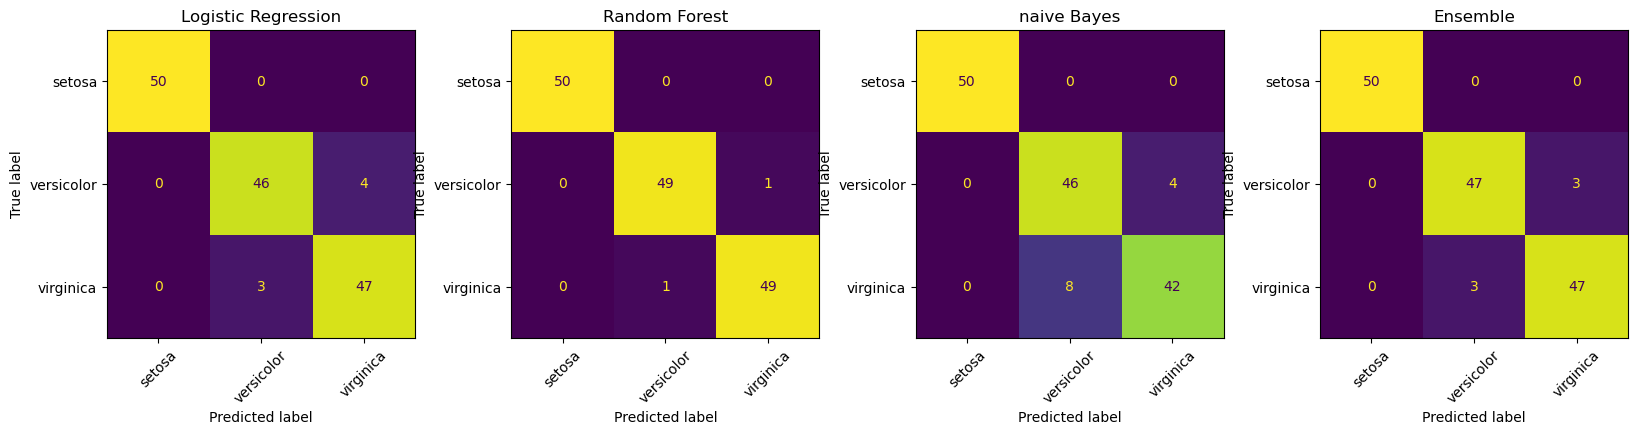

In [2]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 
                                                 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

f, axes = plt.subplots(1, 4, figsize=(20, 4))
for i,(clf, label) in enumerate(zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 
                                                               'Random Forest', 'naive Bayes', 'Ensemble'])):
    y_pred = clf.fit(X, y).predict(X) 
    disp = ConfusionMatrixDisplay(confusion_matrix(y,y_pred), display_labels=iris.target_names)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(label)
    disp.im_.colorbar.remove()

    


## Мягкое головование

В отличие от голосования большинством (жесткое голосование), мягкое голосование возвращает метку класса как $argmax$ суммы предсказанных вероятностей.

Каждому классификатору можно присвоить определенные веса с помощью параметра веса. При указании весов прогнозируемые вероятности классов для каждого классификатора собираются, умножаются на вес классификатора и усредняются. Затем окончательная метка класса получается из метки класса с наибольшей средней вероятностью.

Чтобы проиллюстрировать это на простом примере, давайте предположим, что у нас есть 3 классификатора и задачи классификации с 3 классами, где мы присваиваем всем классификаторам равные веса: 

$w_1=1, w_2=1, w_3=1.$

Затем средневзвешенные вероятности для метки выборки будут рассчитываться следующим образом:

|classifier |	class 1 |	class 2	| class 3|
|------|------|------|-------|
|classifier 1 |	w1 * 0.2 |	w1 * 0.5 |	w1 * 0.3|
|classifier 2 |	w2 * 0.6 | 	w2 * 0.3 | w2 * 0.1|
|classifier 3 |	w3 * 0.3 |	w3 * 0.4 |	w3 * 0.3|
|weighted average |	0.37 |	0.4	 | 0.23 |


Здесь предсказанная метка класса равна 2, так как она имеет самую высокую среднюю вероятность.

В следующем примере показано, как области принятия решений могут измениться, когда используется мягкий классификатор голосования на основе линейной машины опорных векторов, дерева решений и классификатора K-ближайших соседей:



Accuracy: 0.95 (+/- 0.03) [DecisionTree]
Accuracy: 0.94 (+/- 0.04) [KNeighbors]
Accuracy: 0.95 (+/- 0.03) [SVC]
Accuracy: 0.95 (+/- 0.03) [Ensemble]


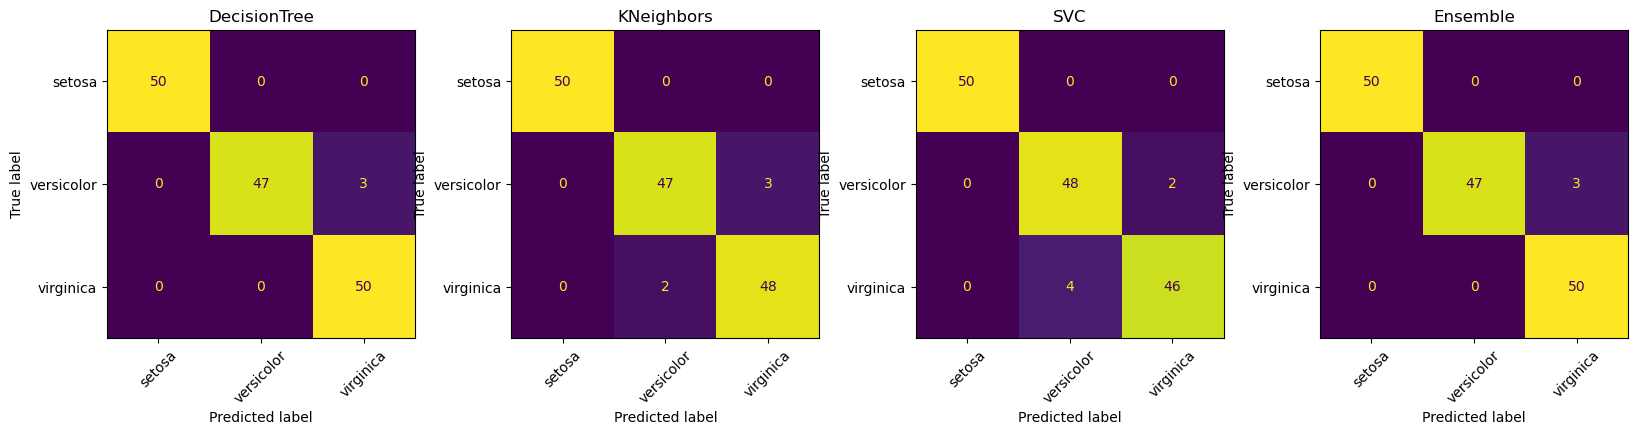

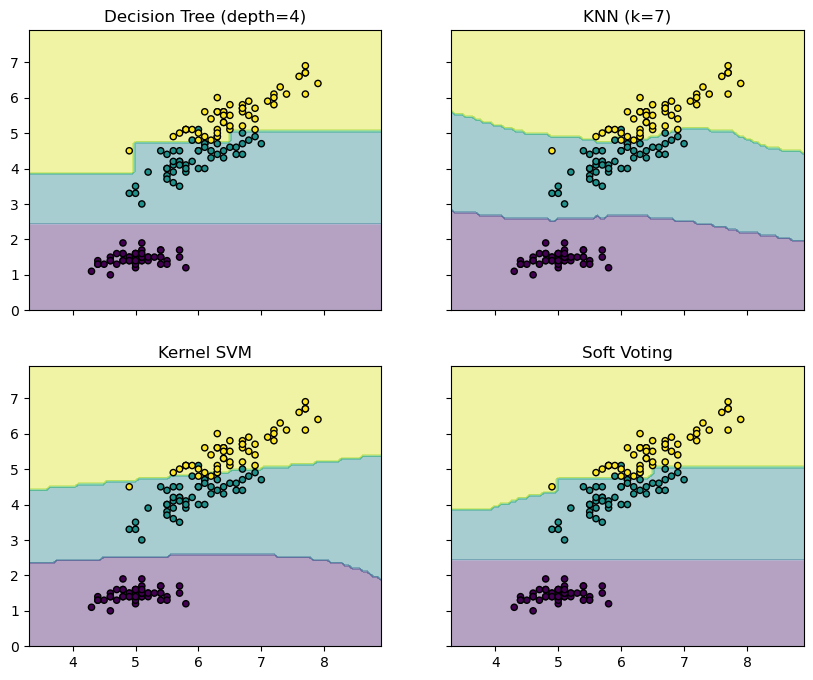

In [6]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

for clf, label in zip([clf1, clf2, clf3, eclf], ['DecisionTree', 
                                                    'KNeighbors', 'SVC', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


f, axes = plt.subplots(1, 4, figsize=(20, 4))
for i,(clf, label) in enumerate(zip([clf1, clf2, clf3, eclf], ['DecisionTree', 
                                                               'KNeighbors', 'SVC', 'Ensemble'])):
    y_pred = clf.fit(X, y).predict(X) 
    disp = ConfusionMatrixDisplay(confusion_matrix(y,y_pred), display_labels=iris.target_names)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(label)
    disp.im_.colorbar.remove()


clf1 = clf1.fit(X, y)
clf2 = clf2.fit(X, y)
clf3 = clf3.fit(X, y)
eclf = eclf.fit(X, y)

# Plotting decision regions
f, axarr = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(10, 8))
for idx, clf, tt in zip(
    product([0, 1], [0, 1]),
    [clf1, clf2, clf3, eclf],
    ["Decision Tree (depth=4)", "KNN (k=7)", "Kernel SVM", "Soft Voting"],
):
    DecisionBoundaryDisplay.from_estimator(
        clf, X, alpha=0.4, ax=axarr[idx[0], idx[1]], response_method="predict"
    )
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Voting Regressor

Идея `VotingRegressor` заключается в объединении концептуально разных регрессионых моделей машинного обучения и возвращении средних прогнозируемых значений. 

Такой регрессор может быть полезен для набора одинаково хорошо работающих моделей, чтобы уравновесить их индивидуальные недостатки.

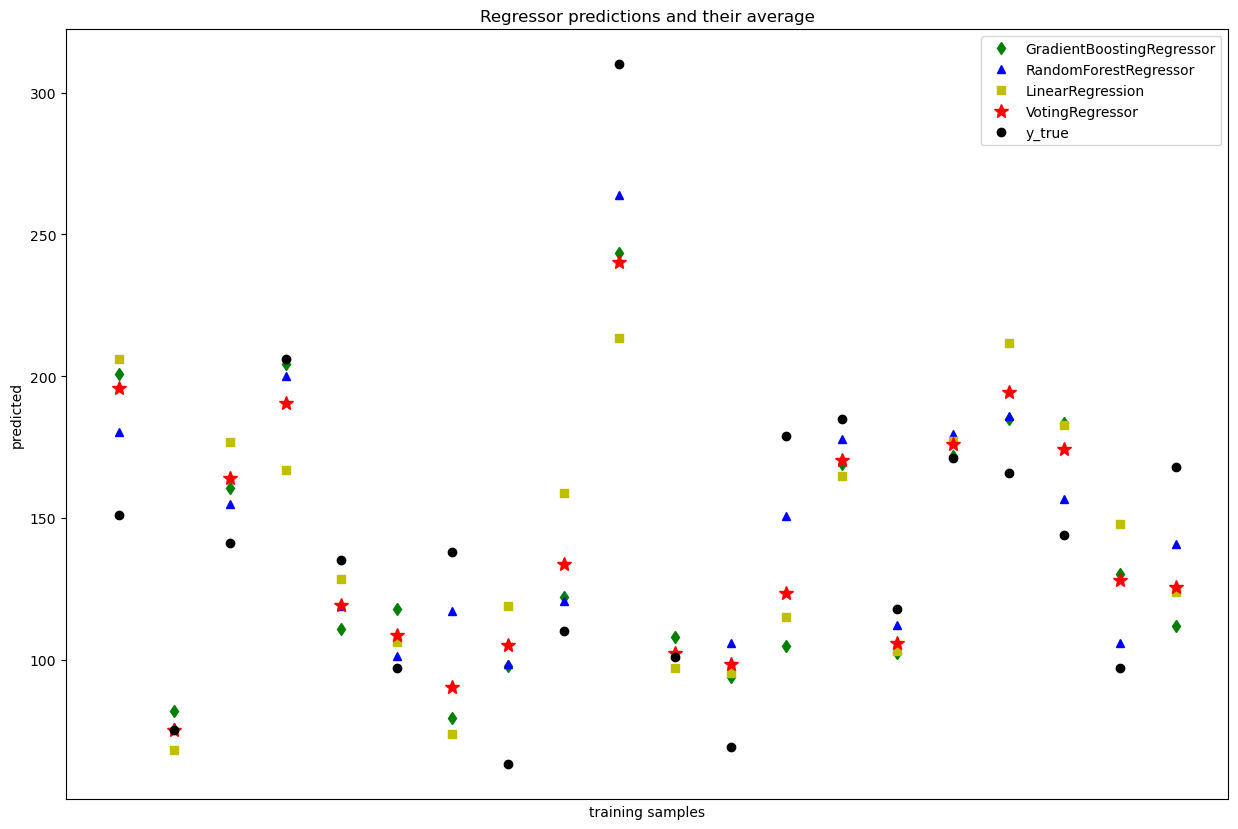

In [18]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

X, y = load_diabetes(return_X_y=True)

# Train classifiers
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()

reg1.fit(X, y)
reg2.fit(X, y)
reg3.fit(X, y)

ereg = VotingRegressor([("gb", reg1), ("rf", reg2), ("lr", reg3)])
ereg.fit(X, y)

# обрезали данные для визуализации
xt = X[:20]
pred1 = reg1.predict(xt)
pred2 = reg2.predict(xt)
pred3 = reg3.predict(xt)
pred4 = ereg.predict(xt)

plt.figure(figsize=(15, 10))
plt.plot(pred1, "gd", label="GradientBoostingRegressor")
plt.plot(pred2, "b^", label="RandomForestRegressor")
plt.plot(pred3, "ys", label="LinearRegression")
plt.plot(pred4, "r*", ms=10, label="VotingRegressor")
plt.plot(y[:20], "ko", label="y_true")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()